In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir(os.path.dirname("../"))

In [445]:
import deepof.data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from deepof.models import *
from itertools import product
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances, r2_score
from tqdm import tqdm

# Tuning of latent space entropy radius

To evaluate how clusters overlap in the latent space, we compute the mean entropy of cluster assignment across all datapoints that fall within a radius of given encoded training instances. This notebook explores how the number of neighbors that fall within that radius on the latent space depends on several variables (ie number of clusters and encoding dimensions).

In [4]:
data_path = "../../Desktop/deepoftesttemp/"

In [30]:
# Load data and tag a few test videos
proj = deepof.data.project(path=data_path, arena_dims=[380]).run()
rules = proj.rule_based_annotation()
coords = proj.get_coords(propagate_annotations=False)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!


100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


In [33]:
list(range(2500, 15001, 2500))

[2500, 5000, 7500, 10000, 12500, 15000]

In [39]:
#Load the models, and try different radii 

# each dataset is rank 3: encoding dimensions, number of clusters, and different radii 
x, y = np.zeros([6, 6, 100]), np.zeros([6, 6, 100])

# Iterate over encoding dimensions
for a,n in enumerate(tqdm(range(2500, 15001, 2500))):
    
    X_train, _, _, _ = coords.preprocess(shuffle=True, window_size=25, test_videos=0)
    X_train = X_train[np.random.choice(range(X_train.shape[0]), n, replace=False)]
    
    for b, d in enumerate((2,4,6,8,10,12)):

        gmvaep = SEQ_2_SEQ_GMVAE(encoding=d, number_of_components=15).build(X_train.shape)[3]
        # Get encoer and grouper from full model
        cluster_means = [
            layer for layer in gmvaep.layers if layer.name == "latent_distribution"
        ][0]
        cluster_assignment = [
            layer for layer in gmvaep.layers if layer.name == "cluster_assignment"
        ][0]

        encoder = tf.keras.models.Model(
            gmvaep.layers[0].input, cluster_means.output
        )
        grouper = tf.keras.models.Model(
            gmvaep.layers[0].input, cluster_assignment.output
        )

        # Use encoder and grouper to predict on validation data
        encoding = encoder.predict(X_train)
        groups = grouper.predict(X_train)

        pdist = pairwise_distances(encoding)

        for i, r in enumerate(np.linspace(0, 5, 100)):
            x[a][b][i], y[a][b][i] = np.round(r, 7), np.median(np.sum(pdist < r, axis=0))

100%|██████████| 6/6 [17:20<00:00, 173.37s/it]


In [421]:
# Select number of average neighbors to aim for
N = 100

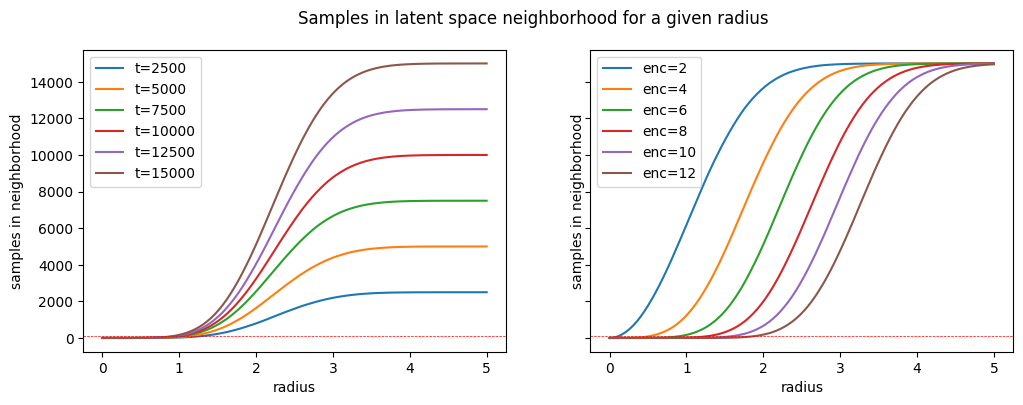

In [422]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k', sharey=True)

plt.suptitle("Samples in latent space neighborhood for a given radius")

# Plot number of neighbors in radius versus number of clusters
for i,t in enumerate(range(2500, 15001, 2500)):
    ax1.plot(x[i][2], y[i][2], label="t={}".format(t))
    
# Plot number of neighbors in radius versus encoding dimensions
for i,d in enumerate([2,4,6,8,10,12]):
    ax2.plot(x[5][i], y[5][i], label="enc={}".format(d))

ax1.set_xlabel("radius")
ax1.set_ylabel("samples in neighborhood")
ax1.legend()
# ax1.set_xlim(0,2)
# ax1.set_ylim(0,100)
ax1.axhline(N, linestyle="--", c="r", linewidth=0.5)

ax2.set_xlabel("radius")
ax2.set_ylabel("samples in neighborhood")
ax2.axhline(N, linestyle="--", c="r", linewidth=0.5)
ax2.legend()

plt.show()

In [423]:
# Fit sigmoid functions to the data in the second plot, and compute the radius that yields K neighbors in average for
# each curve
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def fit_sigmoid(x, y):
    p0 = [max(y), np.median(x),1,min(y)]
    popt, pcov = curve_fit(sigmoid, x, y, p0, method='dogbox')
    return popt

def retrieve_x_from_sigmoid(x, y, n):
    L, x0, k, b = fit_sigmoid(x, y)
    x_given_k = - ( np.log( L/( n-b )-1 ) / k ) + x0
    return x_given_k

In [571]:
# Interpolate to get the radius that will yield n neighbors in each setting
x_given_n = np.zeros([6,6])
_x_given_n = np.zeros([6,6])
y_given_n = np.array([list(range(2500, 15001, 2500)),
                      [2,4,6,8,10,12]])

for i in range(6):
    for j in range(6):
        x_given_n[i][j] = retrieve_x_from_sigmoid(x[i][j], y[i][j], 100)

In [572]:
# Fit a line to the data to get an equation of how #neighbors varies with encoding dimensions
# The retrieved equation will be the default radius!
res1 = linregress(np.log2(y_given_n[0]), x_given_n[:, 2])
print(res1)

res2 = linregress(y_given_n[1], x_given_n[5])
print(res2)

LinregressResult(slope=-0.15312053266151152, intercept=2.913302470467319, rvalue=-0.991863675575361, pvalue=9.903035129076412e-05, stderr=0.009826421392967853)
LinregressResult(slope=0.15871423671061452, intercept=-0.17097475595018974, rvalue=0.9989135628525885, pvalue=1.7698773272193263e-06, stderr=0.0037021779510961407)


In [574]:
# Compute radius for an example
def radius_given_n_and_dim(n, dim, coefs, inpt):
    return coefs[0]*np.log2(n) + coefs[1]*dim + inpt

radius_given_n_and_dim(15000*5, 6, res3.coef_, res3.intercept_)

0.42251736403371165

To select a good default for the radius r, we make the value depend on the variables we find relationships with, such as the number of dimensions in the latent space.

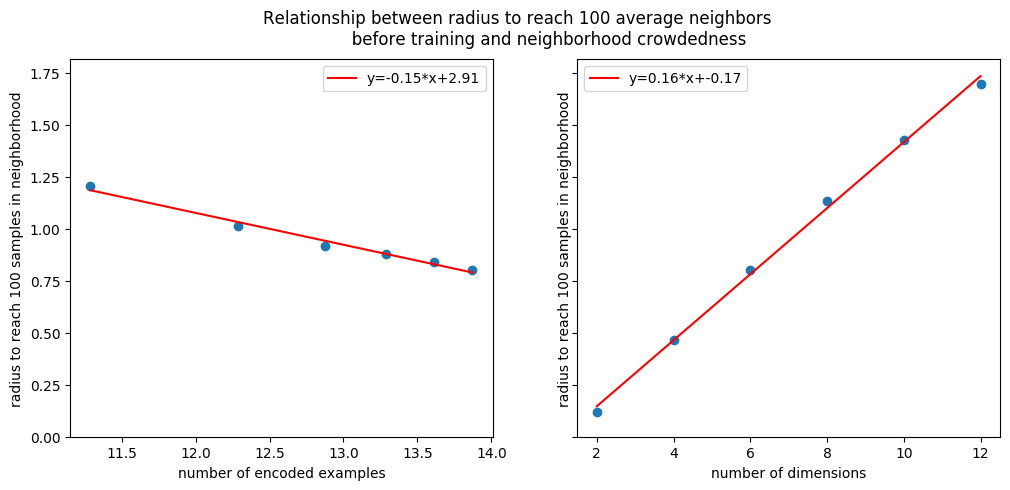

In [427]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k', sharey=True)

ax1.scatter(np.log2(y_given_n[0]), x_given_n[:, 2])
ax1.plot(np.log2(y_given_n[0]), res1.intercept + res1.slope*np.log2(y_given_n[0]), 'r', 
         label='y={}*x+{}'.format(np.round(res1.slope,2), np.round(res1.intercept,2)))
ax1.set_ylabel("radius to reach {} samples in neighborhood".format(N))
ax1.set_xlabel("number of encoded examples")

ax2.scatter(y_given_n[1], x_given_n[5])
ax2.plot(y_given_n[1], res2.intercept + res2.slope*y_given_n[1], 'r', 
         label='y={}*x+{}'.format(np.round(res2.slope,2), np.round(res2.intercept,2)))
ax2.set_ylabel("radius to reach {} samples in neighborhood".format(N))
ax2.set_xlabel("number of dimensions")

plt.suptitle("Relationship between radius to reach {} average neighbors \n \
          before training and neighborhood crowdedness".format(N))

ax1.legend()
ax2.legend()

plt.ylim(0)
plt.show()

In [580]:
# Fit a hyperplane to both features
res3 = LinearRegression()

X = np.array([list(i) for i in product(np.log2(y_given_n[0]), y_given_n[1])])
res3.fit(X, x_given_n.flatten(order="C"))
print("log2(samples) coef: {}\n\
dimension coef: {}".format(*np.round(res3.coef_, 25)))
print("intercept:", np.round(res3.intercept_, 25))
print()
print("r2_score:", np.round(r2_score(x_given_n.flatten(), res3.predict(X)), 5))

log2(samples) coef: -0.14220132706202965
dimension coef: 0.17189696892334544
intercept: 1.6940295848037952

r2_score: 0.99036


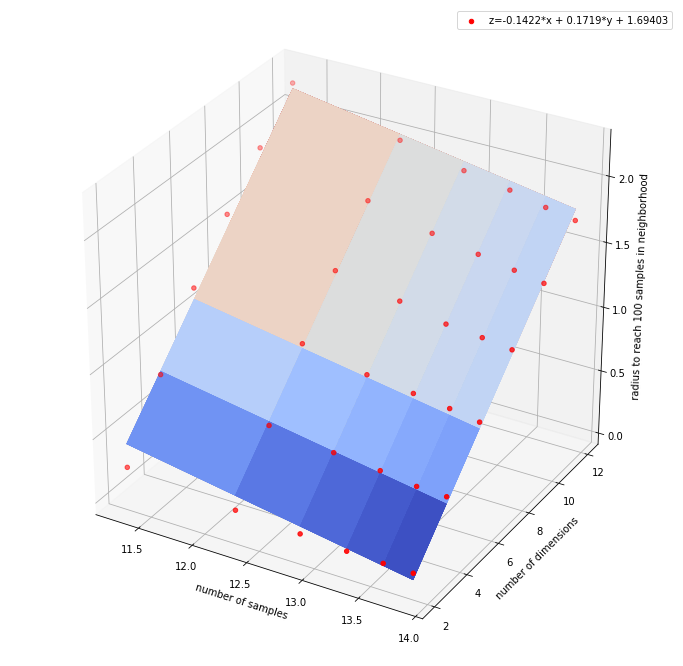

In [428]:
%matplotlib inline

# Let's represent how both variables evolve in a 3D space
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Get combinations of predictors
prod = np.array([list(i) for i in product(y_given_n[0], y_given_n[1])])
n, d = prod[:, 0], prod[:, 1]

ax.scatter3D(np.log2(n), d, x_given_n, c="red",label="z={}*x + {}*y + {}".format(
                    *np.round(res3.coef_, 5),np.round(res3.intercept_, 5)))

x1,x2 = np.meshgrid(X[:,0], X[:,1])
ax.plot_surface(x1, 
                x2, 
                (res3.coef_[0]*x1 + res3.coef_[1]*x2 + res3.intercept_),
                cmap=cm.coolwarm, linewidth=1, antialiased=True,
                
                )


ax.set_xlabel("number of samples")
ax.set_ylabel("number of dimensions")
ax.set_zlabel("radius to reach {} samples in neighborhood".format(N))

ax.legend()
plt.show()
